# Finding the best area in Berlin for a cafe

# 1. Introduction

Berlin is the capital and largest city of Germany with an estimated population of over 3.5 million. It has 12 boroughs and 96 neighborhoods.  

There are a lot of restaurants and places to eat in Berlin and the most common of them is a cafe.

Through this project, we will find the the 'best' neighbourhood in Berlin to open a cafe.

This project is aimed towards entrepreneurs or business owners who want to open a new cafe or grow their current business. 

# 2. Data

The data is taken from multiple sources: the list of boroughs and neighbourhoods - from Wikipedia https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins#cite_note-4), the geographical location of the neighbourhoods - via Geocoder package, and venue data - via Foursquare. 

# 3. Methodology

Let's download all the dependencies that we will need.

In [52]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import seaborn as sns
import folium
import requests

print('Libraries imported.')

Libraries imported.


In [9]:
!pip install geopy 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude value

In [7]:
!pip install geocoder
import geocoder

     |████████████████████████████████| 102kB 9.2MB/s ta 0:00:011


In [20]:
!pip install folium
import folium # map rendering library

In [84]:
!pip install yellowbrick

     |████████████████████████████████| 266kB 9.7MB/s eta 0:00:01


<a id='item1'></a>

## 3.1. Creating of a dataframe

In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Tranform the data into a *pandas* dataframe
The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood

In [10]:
# The code was removed by Watson Studio for sharing.

Ortsteil Bezirk Flache  Einwohner Einwohner_km2
0         Mitte  Mitte  10,70    101.932          9526
1        Moabit  Mitte   7,72     79.512        10.299
2  Hansaviertel  Mitte   0,53      5.894        11.121
3    Tiergarten  Mitte   5,17     14.753          2854
4       Wedding  Mitte   9,23     86.688          9392

In [11]:
df.rename(columns={'Ortsteil': 'Neighborhood', 'Bezirk': 'Borough'}, inplace=True)
df.head()

Neighborhood Borough Flache  Einwohner Einwohner_km2
0         Mitte   Mitte  10,70    101.932          9526
1        Moabit   Mitte   7,72     79.512        10.299
2  Hansaviertel   Mitte   0,53      5.894        11.121
3    Tiergarten   Mitte   5,17     14.753          2854
4       Wedding   Mitte   9,23     86.688          9392

In [12]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 12 boroughs and 96 neighborhoods.


In [13]:
df.shape

print('The dataframe has {} rows.'.format(
        df.shape[0]
    )
)

The dataframe has 96 rows.


# 3.2. Creating of a dataframe with geographical coordinates

In [14]:
#Get geocoordinates of Berlin

address = 'Berlin, Germany'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berlin are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berlin are 52.5170365, 13.3888599.


In [15]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in df["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the initial dataframe
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

df.head()

Neighborhood Borough Flache  Einwohner Einwohner_km2  Latitude  Longitude
0         Mitte   Mitte  10,70    101.932          9526  52.52119   13.42414
1        Moabit   Mitte   7,72     79.512        10.299  52.52570   13.34005
2  Hansaviertel   Mitte   0,53      5.894        11.121  52.51679   13.33835
3    Tiergarten   Mitte   5,17     14.753          2854  52.50993   13.36393
4       Wedding   Mitte   9,23     86.688          9392  52.54781   13.35473

# 3.3. Explore and cluster the neighborhoods in Berlin

Create a map of Berlin with neighborhoods 

In [21]:
# create map of Berlin using latitude and longitude values
map_berlin = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

#### Explore Neighborhoods in Berlin

Use the Foursquare API to explore the neighborhoods and segment them.

Define Foursquare Credentials and Version

In [22]:
CLIENT_ID = 'E2QA0LXBWHZBWVRCIS1BDYPYZS3EB0KAUNEN0NDYQAVX2PLT' # your Foursquare ID
CLIENT_SECRET = 'BOHJIKTQWZ2KTH4HRPIE0IUJLPFFDTALKBHGMDRVDLSP5IP4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [23]:
#define the median of areas of neighborhoods
df['Flache'] = (df['Flache'].replace('\.','', regex=True)
                        .replace(',','.', regex=True)
                        .astype(float))
avg_F = df["Flache"].median()
print('The median of areas of neighborhoods in Berlin is {} km2.'.format(avg_F))

The median of areas of neighborhoods in Berlin is 7.76 km2.


Let's create a function to get the venues that are in the neighborhoods of Berlin within a radius of 1300 meters


In [56]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=1300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Create a new dataframe called *berlin_venues*.

In [57]:
berlin_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Mitte
Moabit
Hansaviertel
Tiergarten
Wedding
Gesundbrunnen
Friedrichshain
Kreuzberg
Prenzlauer Berg
Weißensee
Blankenburg
Heinersdorf
Karow
Stadtrandsiedlung Malchow
Pankow
Blankenfelde
Buch
Französisch Buchholz
Niederschönhausen
Rosenthal
Wilhelmsruh
Charlottenburg
Wilmersdorf
Schmargendorf
Grunewald
Westend
Charlottenburg-Nord
Halensee
Spandau
Haselhorst
Siemensstadt
Staaken
Gatow
Kladow
Hakenfelde
Falkenhagener Feld
Wilhelmstadt
Steglitz
Lichterfelde
Lankwitz
Zehlendorf
Dahlem
Nikolassee
Wannsee
Schöneberg
Friedenau
Tempelhof
Mariendorf
Marienfelde
Lichtenrade
Neukölln
Britz
Buckow
Rudow
Gropiusstadt
Alt-Treptow
Plänterwald
Baumschulenweg
Johannisthal
Niederschöneweide
Altglienicke
Adlershof
Bohnsdorf
Oberschöneweide
Köpenick
Friedrichshagen
Rahnsdorf
Grünau
Müggelheim
Schmöckwitz
Marzahn
Biesdorf
Kaulsdorf
Mahlsdorf
Hellersdorf
Friedrichsfelde
Karlshorst
Lichtenberg
Falkenberg
Malchow
Wartenberg
Neu-Hohenschönhausen
Alt-Hohenschönhausen
Fennpfuhl
Rummelsburg
Reinickendorf
Tegel
Kon

Let's check the size of the resulting dataframe

In [59]:
print(berlin_venues.shape)
berlin_venues.head()

(4300, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0        Mitte               52.52119                13.42414   
1        Mitte               52.52119                13.42414   
2        Mitte               52.52119                13.42414   
3        Mitte               52.52119                13.42414   
4        Mitte               52.52119                13.42414   

                                Venue  Venue Latitude  Venue Longitude  \
0                  Kino International       52.520363        13.422849   
1  Fahrrad Flöckner I CUBE Bike Store       52.519152        13.424692   
2                   Ristorante a Mano       52.518772        13.427652   
3                               CAMP4       52.520032        13.421953   
4                           BoConcept       52.518643        13.426828   

           Venue Category  
0     Indie Movie Theater  
1               Bike Shop  
2      Italian Restaurant  
3    Outdoor Supply Store  
4  Furniture / Home Store

Let's check how many venues were returned for each neighborhood

In [60]:
berlin_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                               
Adlershof                                     35                      35   
Alt-Hohenschönhausen                          34                      34   
Alt-Treptow                                  100                     100   
Altglienicke                                  17                      17   
Baumschulenweg                                30                      30   
Biesdorf                                      23                      23   
Blankenburg                                    6                       6   
Blankenfelde                                   4                       4   
Bohnsdorf                                      9                       9   
Borsigwalde                                   21                      21   
Britz                                         34                      34   
Buch                                          12                      12   
Buckow                                        15                      15   
Charlottenburg                               100                     100   
Charlottenburg-Nord                           67                      67   
Dahlem                                        44                      44   
Falkenberg                                    11                      11   
Falkenhagener Feld                            13                      13   
Fennpfuhl                                    100                     100   
Französisch Buchholz                          11                      11   
Friedenau                                    100                     100   
Friedrichsfelde                               61                      61   
Friedrichshagen                               40                      40   
Friedrichshain                               100                     100   
Frohnau                                       18                      18   
Gatow                                         14                      14   
Gesundbrunnen                                 76                      76   
Gropiusstadt                                  34                      34   
Grunewald                                     65                      65   
Grünau                                        21                      21   
Hakenfelde                                    19                      19   
Halensee                                     100                     100   
Hansaviertel                                 100                     100   
Haselhorst                                    32                      32   
Heiligensee                                    7                       7   
Heinersdorf                                   26                      26   
Hellersdorf                                   40                      40   
Hermsdorf                                     28                      28   
Johannisthal                                  23                      23   
Karlshorst                                    36                      36   
Karow                                         10                      10   
Kaulsdorf                                     26                      26   
Kladow                                        11                      11   
Konradshöhe                                    6                       6   
Kreuzberg                                    100                     100   
Köpenick                                      49                      49   
Lankwitz                                      42                      42   
Lichtenberg                                  100                     100   
Lichtenrade                                   26                      26   
Lichterfelde                                  26                      26   
Lübars                                         4                       4   

Let's find out how many unique categories can be curated from all the returned venues

In [61]:
print('There are {} uniques categories.'.format(len(berlin_venues['Venue Category'].unique())))

There are 355 uniques categories.


In [62]:
print('Top 10 distinct venue counts are as below')
berlin_venues[['Venue','Venue Category']].drop_duplicates().groupby('Venue Category').count()[['Venue']].rename(columns={"Venue": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


Count
Venue Category           
Café                  198
Italian Restaurant    143
Hotel                  99
German Restaurant      96
Bus Stop               96
Park                   85
Bakery                 85
Bar                    73
Ice Cream Shop         72
Coffee Shop            65

In [63]:
berlin_venues[['Venue','Venue Category']].drop_duplicates().groupby('Venue Category').count()[['Venue']].rename(columns={"Venue": "Count"}).sort_values(by=['Count'], ascending=False)

Count
Venue Category                                 
Café                                        198
Italian Restaurant                          143
Hotel                                        99
German Restaurant                            96
Bus Stop                                     96
Park                                         85
Bakery                                       85
Bar                                          73
Ice Cream Shop                               72
Coffee Shop                                  65
Supermarket                                  59
Plaza                                        58
Tram Station                                 56
Restaurant                                   54
Pizza Place                                  48
Trattoria/Osteria                            40
Vietnamese Restaurant                        38
Asian Restaurant                             38
Chinese Restaurant                           35
Doner Restaurant                             34
Light Rail Station                           34
Indian Restaurant                            32
Soccer Field                                 31
Greek Restaurant                             28
Gym / Fitness Center                         27
Cocktail Bar                                 26
Shopping Mall                                25
Lake                                         25
Falafel Restaurant                           22
Vegetarian / Vegan Restaurant                22
Sushi Restaurant                             22
Thai Restaurant                              21
Burger Joint                                 21
Pub                                          21
Nightclub                                    20
Metro Station                                20
Breakfast Spot                               20
Beer Garden                                  18
Korean Restaurant                            18
Turkish Restaurant                           17
Zoo Exhibit                                  17
Bistro                                       17
Indie Movie Theater                          17
Middle Eastern Restaurant                    17
Japanese Restaurant                          16
Fast Food Restaurant                         16
Grocery Store                                16
Furniture / Home Store                       15
Gastropub                                    15
Art Museum                                   15
Pool                                         15
Gourmet Shop                                 15
Beach                                        14
Harbor / Marina                              14
Playground                                   14
Dessert Shop                                 14
Hostel                                       13
Historic Site                                13
Theater                                      13
Athletics & Sports                           13
Clothing Store                               13
Art Gallery                                  12
Mediterranean Restaurant                     12
Automotive Shop                              12
Seafood Restaurant                           11
Pet Store                                    11
Scenic Lookout                               11
History Museum                               11
Music Venue                                  11
Bookstore                                    11
Taverna                                      11
Brewery                                      11
Boat or Ferry                                10
Steakhouse                                   10
Farmers Market                               10
Pastry Shop                                  10
Liquor Store                                 10
French Restaurant                            10
Gym                                          10
Organic Grocery                               9
Beer Bar                                      9
Platform                                      9
Movie Thea

<a id='item3'></a>

#### Analyzing of each neighborhood

In [64]:
# one hot encoding
onehot = pd.get_dummies(berlin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = berlin_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

Zoo Exhibit  ATM  Adult Boutique  African Restaurant  American Restaurant  \
0            0    0               0                   0                    0   
1            0    0               0                   0                    0   
2            0    0               0                   0                    0   
3            0    0               0                   0                    0   
4            0    0               0                   0                    0   

   Animal Shelter  Aquarium  Argentinian Restaurant  Art Gallery  Art Museum  \
0               0         0                       0            0           0   
1               0         0                       0            0           0   
2               0         0                       0            0           0   
3               0         0                       0            0           0   
4               0         0                       0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0                    0                 0                   0   
1                    0                 0                   0   
2                    0                 0                   0   
3                    0                 0                   0   
4                    0                 0                   0   

   Austrian Restaurant  Auto Dealership  Auto Garage  Auto Workshop  \
0                    0                0            0              0   
1                    0                0            0              0   
2                    0                0            0              0   
3                    0                0            0              0   
4                    0                0            0              0   

   Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0                0          0           0           0       0     0    0   
1                0          0           0           0       0     0    0   
2                0          0           0           0       0     0    0   
3                0          0           0           0       0     0    0   
4                0          0           0           0       0     0    0   

   Bath House  Bavarian Restaurant  Beach  Beach Bar  Bed & Breakfast  \
0           0                    0      0          0                0   
1           0                    0      0          0                0   
2           0                    0      0          0                0   
3           0                    0      0          0                0   
4           0                    0      0          0                0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0         0            0           0              0                         0   
1         0            0           0              0                         0   
2         0            0           0              0                         0   
3         0            0           0              0                         0   
4         0            0           0              0                         0   

   Bike Shop  Bistro  Board Shop  Boarding House  Boat Rental  Boat or Ferry  \
0          0       0           0               0            0              0   
1          1       0           0               0            0              0   
2          0       0           0               0            0              0   
3          0       0           0               0            0              0   
4          0       0           0               0            0              0   

   Bookstore  Botanical Garden  Boutique  Bowling Alley  Brasserie  \
0          0                 0         0              0          0   
1          0                 0         0              0          0   
2          0                 0         0              0          0   
3          0                 0         0              0          0   
4          0   

And let's examine the new dataframe size.

In [68]:
onehot.shape

(4300, 355)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [69]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped.head()

Neighborhood  Zoo Exhibit  ATM  Adult Boutique  African Restaurant  \
0             Adlershof          0.0  0.0             0.0                 0.0   
1  Alt-Hohenschönhausen          0.0  0.0             0.0                 0.0   
2           Alt-Treptow          0.0  0.0             0.0                 0.0   
3          Altglienicke          0.0  0.0             0.0                 0.0   
4        Baumschulenweg          0.0  0.0             0.0                 0.0   

   American Restaurant  Animal Shelter  Aquarium  Argentinian Restaurant  \
0                  0.0             0.0       0.0                     0.0   
1                  0.0             0.0       0.0                     0.0   
2                  0.0             0.0       0.0                     0.0   
3                  0.0             0.0       0.0                     0.0   
4                  0.0             0.0       0.0                     0.0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0         0.00    0.000000                  0.0              0.00   
1         0.00    0.029412                  0.0              0.00   
2         0.01    0.000000                  0.0              0.01   
3         0.00    0.000000                  0.0              0.00   
4         0.00    0.000000                  0.0              0.00   

   Athletics & Sports  Austrian Restaurant  Auto Dealership  Auto Garage  \
0                0.00                  0.0             0.00          0.0   
1                0.00                  0.0             0.00          0.0   
2                0.01                  0.0             0.01          0.0   
3                0.00                  0.0             0.00          0.0   
4                0.00                  0.0             0.00          0.0   

   Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  \
0            0.0         0.028571        0.0         0.0         0.0   
1            0.0         0.058824        0.0         0.0         0.0   
2            0.0         0.000000        0.0         0.0         0.0   
3            0.0         0.000000        0.0         0.0         0.0   
4            0.0         0.000000        0.0         0.0         0.0   

     Bakery      Bank       Bar  Bath House  Bavarian Restaurant     Beach  \
0  0.000000  0.028571  0.000000         0.0                  0.0  0.000000   
1  0.058824  0.000000  0.029412         0.0                  0.0  0.029412   
2  0.020000  0.000000  0.030000         0.0                  0.0  0.000000   
3  0.058824  0.000000  0.000000         0.0                  0.0  0.000000   
4  0.066667  0.000000  0.000000         0.0                  0.0  0.000000   

   Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0        0.0              0.0       0.0         0.00         0.0   
1        0.0              0.0       0.0         0.00         0.0   
2        0.0              0.0       0.0         0.02         0.0   
3        0.0              0.0       0.0         0.00         0.0   
4        0.0              0.0       0.0         0.00         0.0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Bistro  Board Shop  \
0       0.028571                       0.0       0.00     0.0         0.0   
1       0.029412                       0.0       0.00     0.0         0.0   
2       0.010000                       0.0       0.01     0.0         0.0   
3       0.000000                       0.0       0.00     0.0         0.0   
4       0.000000                       0.0       0.00     0.0         0.0   

   Boarding House  Boat Rental  Boat or Ferry  Bookstore  Botanical Garden  \
0             0.0          0.0       0.000000        0.0               0.0   
1             0.0          0.0       0.000000        0.0               0.0   
2             0.0          0.0       0.000000        0.0               0.0   
3             0.0          0.0       0.000000        0.0               0.0   
4             0.0          0.0 

Let's confirm the new size

In [70]:
grouped.shape

(96, 355)

Let's print each neighborhood along with the top 5 most common venues

In [71]:
num_top_venues = 5

for hood in grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = grouped[grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adlershof----
              venue  freq
0       Supermarket  0.09
1             Hotel  0.06
2             Plaza  0.06
3          Bus Stop  0.06
4  Greek Restaurant  0.06


----Alt-Hohenschönhausen----
              venue  freq
0       Supermarket  0.09
1   Automotive Shop  0.06
2              Café  0.06
3              Lake  0.06
4  Greek Restaurant  0.06


----Alt-Treptow----
                   venue  freq
0                   Café  0.07
1              Nightclub  0.07
2  Vietnamese Restaurant  0.04
3              Rock Club  0.04
4                   Park  0.04


----Altglienicke----
                venue  freq
0         Supermarket  0.24
1                Café  0.12
2           Cafeteria  0.06
3        Tram Station  0.06
4  Italian Restaurant  0.06


----Baumschulenweg----
         venue  freq
0  Supermarket  0.10
1     Bus Stop  0.07
2     Platform  0.07
3         Café  0.07
4         Park  0.07


----Biesdorf----
                    venue  freq
0  Furniture / Home Store  0.13
1     

Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [72]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [73]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0             Adlershof           Supermarket                 Hotel   
1  Alt-Hohenschönhausen           Supermarket          Tram Station   
2           Alt-Treptow             Nightclub                  Café   
3          Altglienicke           Supermarket                  Café   
4        Baumschulenweg           Supermarket                  Park   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0              Bus Stop      Greek Restaurant                 Plaza   
1      Greek Restaurant                  Lake                  Café   
2                  Park             Rock Club           Coffee Shop   
3   Rental Car Location          Tram Station             Drugstore   
4                Bakery             Drugstore              Bus Stop   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0            Gas Station         Big Box Store                  Park   
1                 Bakery             Drugstore       Automotive Shop   
2  Vietnamese Restaurant                   Bar     Indian Restaurant   
3      Electronics Store             Cafeteria            Food Truck   
4               Platform                  Café                  Pier   

  9th Most Common Venue 10th Most Common Venue  
0     German Restaurant        Automotive Shop  
1                   Bar          Rugby Stadium  
2        Ice Cream Shop      German Restaurant  
3          Liquor Store       Greek Restaurant  
4    Chinese Restaurant             Smoke Shop

Filter cafes out of all venues

In [74]:
"Café" in berlin_venues['Venue Category'].unique()


True

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of cafes

In [75]:
cafe = grouped[["Neighborhood","Café"]]
cafe.head()

Neighborhood      Café
0             Adlershof  0.028571
1  Alt-Hohenschönhausen  0.058824
2           Alt-Treptow  0.070000
3          Altglienicke  0.117647
4        Baumschulenweg  0.066667

## 3.4. Cluster Neighborhoods

We will use k-means clustering. But first we will find the best K using the Elbow Point method.

In [91]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = cafe.drop(['Neighborhood'], axis=1)

In [100]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 1, 1, 0, 3, 4, 2, 3, 3], dtype=int32)

In [101]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [102]:
scores = [get_inertia(x) for x in range(2, 21)]

Text(0, 0.5, 'Error')

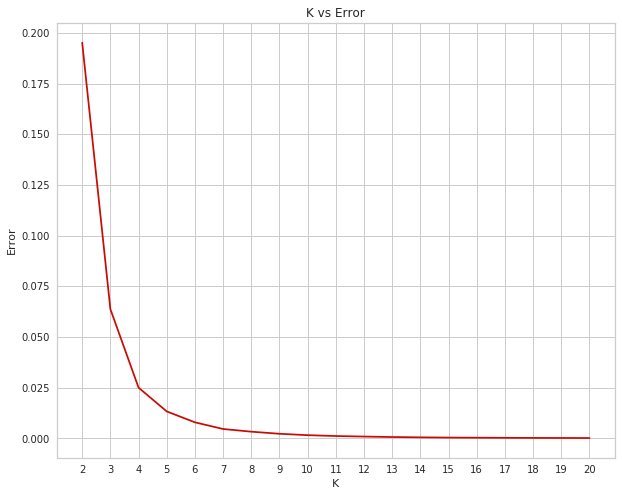

In [103]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [104]:
from yellowbrick.cluster import KElbowVisualizer

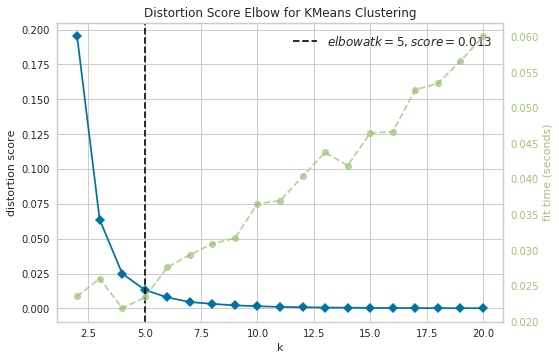

In [105]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

We see that the optimum K value is 5 so we will have a resulting of 5 clusters

Run k-means to cluster the neighborhood into 5 clusters. Neighbourhoods that had a similar mean frequency of Italian Restaurants were divided into 5 clusters. Each of these clusters was labelled from 0 to 4 as the indexing of labels begins with 0 instead of 1.

In [106]:
# set number of clusters
kclusters = 5

grouped_clustering = cafe.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 1, 0, 3, 4, 2, 3, 3], dtype=int32)

In [147]:
# create a new dataframe 
merged = cafe.copy()

# add clustering labels
merged["Cluster"] = kmeans.labels_

# mergedata to add latitude/longitude for each neighborhood
merged = merged.join(berlin_venues.set_index('Neighborhood'), on='Neighborhood')

print(merged.shape)
merged.head()

(4300, 9)


Neighborhood      Café  Cluster  Neighborhood Latitude  \
0    Adlershof  0.028571        0               52.43779   
0    Adlershof  0.028571        0               52.43779   
0    Adlershof  0.028571        0               52.43779   
0    Adlershof  0.028571        0               52.43779   
0    Adlershof  0.028571        0               52.43779   

   Neighborhood Longitude                          Venue  Venue Latitude  \
0                13.54778                    Mia Toscana       52.438327   
0                13.54778  Griechisches Restaurant Athen       52.434901   
0                13.54778             Olympia Greek Food       52.433982   
0                13.54778                          McFIT       52.431000   
0                13.54778              dm-drogerie markt       52.437611   

   Venue Longitude        Venue Category  
0        13.549573    Italian Restaurant  
0        13.546680      Greek Restaurant  
0        13.538500      Greek Restaurant  
0        13.549495  Gym / Fitness Center  
0        13.547728             Drugstore

Lets check how many cafes are there

In [148]:
merged['Venue Category'].value_counts()['Café']

221

Finally, let's visualize the resulting clusters

In [150]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Neighborhood Latitude'], merged['Neighborhood Longitude'], merged['Neighborhood'], merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 1 — Red

Cluster 2 — Violet

Cluster 3 — Blue

Cluster 4 — Green

Claster 5 - Orange

## 3.5 Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

How many Neighborhoods per Cluster?

In [192]:
cafe["Cluster"] = kmeans.labels_
cafe.sort_values(by=['Cluster', 'Café'])

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Neighborhood      Café  Cluster
55                    Marzahn  0.024390        0
36                Hellersdorf  0.025000        0
58         Märkisches Viertel  0.025000        0
0                   Adlershof  0.028571        0
14        Charlottenburg-Nord  0.029851        0
56                      Mitte  0.030000        0
73                Rummelsburg  0.030303        0
92               Wilhelmstadt  0.031250        0
78                    Spandau  0.032258        0
65            Oberschöneweide  0.037736        0
48                Lichtenrade  0.038462        0
49               Lichterfelde  0.038462        0
31                   Halensee  0.040000        0
91                Wilhelmsruh  0.041667        0
83                  Tempelhof  0.044944        0
28                  Grunewald  0.046154        0
29                     Grünau  0.047619        0
18                  Fennpfuhl  0.050000        0
47                Lichtenberg  0.050000        0
61                   Neukölln  0.050000        0
63          Niederschönhausen  0.050000        0
81                   Steglitz  0.050000        0
26              Gesundbrunnen  0.052632        0
24                    Frohnau  0.055556        0
39                 Karlshorst  0.055556        0
64                 Nikolassee  0.055556        0
1        Alt-Hohenschönhausen  0.058824        0
74              Schmargendorf  0.060000        0
82                      Tegel  0.062500        0
90                    Westend  0.065934        0
4              Baumschulenweg  0.066667        0
62          Niederschöneweide  0.066667        0
2                 Alt-Treptow  0.070000        1
13             Charlottenburg  0.070000        1
22            Friedrichshagen  0.075000        1
17         Falkenhagener Feld  0.076923        1
44                  Kreuzberg  0.080000        1
57                     Moabit  0.080000        1
11                       Buch  0.083333        1
72                      Rudow  0.086957        1
27               Gropiusstadt  0.088235        1
76                 Schöneberg  0.090000        1
69                  Rahnsdorf  0.090909        1
23             Friedrichshain  0.100000        1
95                 Zehlendorf  0.108696        1
68            Prenzlauer Berg  0.110000        1
15                     Dahlem  0.113636        1
3                Altglienicke  0.117647        1
20                  Friedenau  0.120000        1
7                Blankenfelde  0.500000        2
5                    Biesdorf  0.000000        3
8                   Bohnsdorf  0.000000        3
9                 Borsigwalde  0.000000        3
10                      Britz  0.000000        3
12                     Buckow  0.000000        3
16                 Falkenberg  0.000000        3
19       Französisch Buchholz  0.000000        3
25                      Gatow  0.000000        3
30                 Hakenfelde  0.000000        3
33                 Haselhorst  0.000000        3
34                Heiligensee  0.000000        3
35                Heinersdorf  0.000000        3
37                  Hermsdorf  0.000000        3
38               Johannisthal  0.000000        3
40                      Karow  0.000000        3
41                  Kaulsdorf  0.000000        3
42                     Kladow  0.000000        3
43                Konradshöhe  0.000000        3
46                   Lankwitz  0.000000        3
50                     Lübars  0.000000        3
51                  Mahlsdorf  0.000000        3
52                    Malchow  0.000000        3
53                 Mariendorf  0.000000        3
54                Marienfelde  0.000000        3
60       Neu-Hohenschönhausen  0.000000        3
67                Plänterwald  0.000000        3
70              Reinickendorf  0.000000        3
71                  Rosenthal  0.000000        3
75                Schmöckwitz  0.000000        3
77               Siemensstadt  0.000000        3
79                    Staaken  0.000000        3

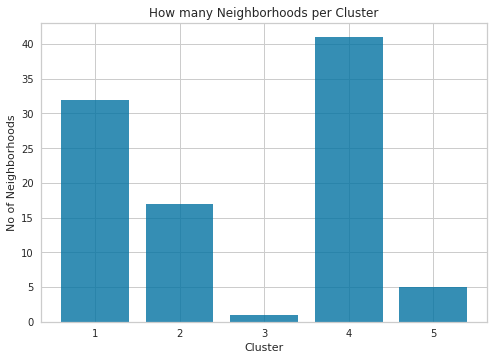

In [154]:
objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
performance = cafe['Cluster'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [155]:
# How many neighborhoods in each cluster
cafe['Cluster'].value_counts()

3    41
0    32
1    17
4     5
2     1
Name: Cluster, dtype: int64

Analysis of each Cluster

Cluster 1

In [195]:
# Red
cluster1 = merged.loc[merged['Cluster'] == 0]
df_cluster1 = pd.merge(df, cluster1, on='Neighborhood')
df_cluster1['Café'].mean()

0.04515778019586473

Cluster 2

In [196]:
# Purple 
cluster2 = merged.loc[merged['Cluster'] == 1]
df_cluster2 = pd.merge(df, cluster2, on='Neighborhood')
df_cluster2['Café'].mean()

0.09134615384615431

Cluster 3

In [197]:
# Blue
cluster3 = merged.loc[merged['Cluster'] == 2]
df_cluster3 = pd.merge(df, cluster3, on='Neighborhood')
df_cluster3['Café'].mean()

0.5

Cluster 4

In [198]:
# Green
cluster4 = merged.loc[merged['Cluster'] == 3]
df_cluster4 = pd.merge(df, cluster4, on='Neighborhood')
df_cluster4['Café'].mean()

0.004266211604095555

Cluster 5

In [199]:
# Orange
cluster5 = merged.loc[merged['Cluster'] == 4]
df_cluster5 = pd.merge(df, cluster5, on='Neighborhood')
df_cluster5['Café'].mean()

0.14634146341463403

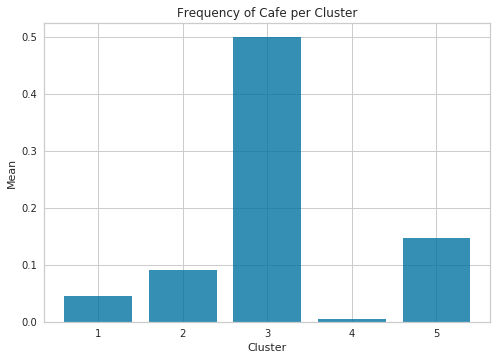

In [200]:
clusters_mean = [df_cluster1['Café'].mean(),df_cluster2['Café'].mean(),df_cluster3['Café'].mean(),
                 df_cluster4['Café'].mean(),df_cluster5['Café'].mean()]
objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Frequency of Cafe per Cluster')

plt.show()

In [ ]:
# average number of cafe per cluster
cafe['Cluster'].value_counts()

# 4. Results and Discussion

We can see that there is only 1 neighbourhood in Cluster 3, and it has the highest frequency of cafe (0.5). 

The Claster 4 has the most number of neighboorhoods (41) and the lowest frequency of cafe among venues (0.004). From the map, we can see that neighbourhoods in Cluster 4 are located quite sparsely. 

So we can conclude that the optimal place to open a cafe is a neighboorhood of Claster 4, with little to no competition.

In [205]:
# Recommended neighborhoods
df_cluster4['Neighborhood'].unique()

array(['Hansaviertel', 'Tiergarten', 'Weißensee', 'Heinersdorf', 'Karow',
       'Stadtrandsiedlung Malchow', 'Französisch Buchholz', 'Rosenthal',
       'Wilmersdorf', 'Haselhorst', 'Siemensstadt', 'Staaken', 'Gatow',
       'Kladow', 'Hakenfelde', 'Lankwitz', 'Wannsee', 'Mariendorf',
       'Marienfelde', 'Britz', 'Buckow', 'Plänterwald', 'Johannisthal',
       'Bohnsdorf', 'Schmöckwitz', 'Biesdorf', 'Kaulsdorf', 'Mahlsdorf',
       'Friedrichsfelde', 'Falkenberg', 'Malchow', 'Wartenberg',
       'Neu-Hohenschönhausen', 'Reinickendorf', 'Konradshöhe',
       'Heiligensee', 'Hermsdorf', 'Waidmannslust', 'Lübars', 'Wittenau',
       'Borsigwalde'], dtype=object)

# 5. Conclusion

Purpose of this project was find the the 'best' neighbourhoods in Berlin to open a cafe.

Final decission on optimal cafe location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors.